In [1]:
# set up matplotlib
%matplotlib widget
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams.update({"font.size": 14})

In [2]:
import numpy as np
import xarray as xr
from scipy.special import j0
from scipy.interpolate import RectBivariateSpline
from xbout import open_boutdataset

In [3]:
case = "1" # Case 1 is for anomalous density diffusion only.
filepath = "mms" + str(case) + "_ncut/BOUT.dmp.*.nc"
#filepath = "test" + str(case) + "/BOUT.dmp.0.nc"

ds = open_boutdataset(datapath=filepath, chunks={"t": 4})
dsn = xr.open_dataset("circle_lowestres_cut.fci.nc")

# Use squeeze() to get rid of the y-dimension, which has length 1 usually unless turbulent.
ds = ds.squeeze(drop=True)
dsn = dsn.squeeze(drop=True)

for key,val in ds.items():
    print(key)

Read in:
<xbout.BoutDataset>
Contains:
<xarray.Dataset> Size: 46MB
Dimensions:             (x: 68, y: 1, z: 68, t: 201)
Coordinates:
    dx                  (x, y, z) float64 37kB dask.array<chunksize=(68, 1, 68), meta=np.ndarray>
    dy                  (x, y, z) float64 37kB dask.array<chunksize=(68, 1, 68), meta=np.ndarray>
    dz                  (x, y, z) float64 37kB dask.array<chunksize=(68, 1, 68), meta=np.ndarray>
  * t                   (t) float64 2kB 0.0 5e+05 1e+06 ... 9.95e+07 1e+08
  * x                   (x) int64 544B 0 1 2 3 4 5 6 7 ... 61 62 63 64 65 66 67
  * y                   (y) float64 8B 0.1963
  * z                   (z) float64 544B 0.007353 0.02206 ... 0.9779 0.9926
Data variables: (12/52)
    Bxy                 (x, y, z) float64 37kB dask.array<chunksize=(68, 1, 68), meta=np.ndarray>
    G1                  (x, y, z) float64 37kB dask.array<chunksize=(68, 1, 68), meta=np.ndarray>
    G2                  (x, y, z) float64 37kB dask.array<chunksize=(68, 1, 

/home/tirkas1/miniconda3/lib/python3.13/site-packages/xbout/load.py:341: UserWarning: No geometry type found, no physical coordinates will be added
  warn("No geometry type found, no physical coordinates will be added")


In [4]:
dx = ds["dx"].isel(z=0).values

# Get rid of existing "x" coordinate, which is just the index values.
#ds = ds.drop("x")

# Create a new coordinate, which is length in units of rho_s
ds = ds.assign_coords(x=np.arange(ds.sizes["x"])*dx)

#Store just initial values as well.
ds_initial = ds.isel(t=0)

In [5]:
dens = ds["Nh+"][:,2:-2,:]
dens_true = dens.copy()

mask = dsn["in_mask"][2:-2,:]
ghost_id = dsn["ghost_id"].values
gst_pts = dsn["ghost_pts"].values
bdy_pts = dsn["bndry_pts"].values
img_pts = dsn["image_pts"].values
normals = dsn["normals"].values
is_plasma = dsn["is_plasma"].values
Rarr = dsn["R"].values[2:-2,:]
Zarr = dsn["Z"].values

timestep_for_errs_early = 10
timestep_for_errs_late = 100
spl_e = RectBivariateSpline(Rarr[:,0], Zarr[0,:], dens.values[timestep_for_errs_early,:,:], kx=1, ky=1)
spl_l = RectBivariateSpline(Rarr[:,0], Zarr[0,:], dens.values[timestep_for_errs_late,:,:], kx=1, ky=1)

In [6]:
beta0 = 3.8317059702075125
xc, zc = 1.5, 0.0

x_unit = 0.00022846974366979959 #rho_s0
w_unit = 95788333.030660808    #Omega_ci
t_unit = 1/w_unit

nx = 64*int(case)
nz = nx + 4
dx = np.float64(1.0) / np.float64(nx)
dz = np.float64(1.0) / np.float64(nz)

# Centers in x; faces/nodes in z if that's your convention
x = (np.arange(nx, dtype=np.float64) + 0.5) * dx     # centered x
z = (np.arange(nz, dtype=np.float64)) * dz           # unshifted z

xhalf  = np.float64(x[len(x)//2])
zhalf  = np.float64(z[len(z)//2])

print(xhalf)

xx, zz = np.meshgrid(x,z,indexing='ij',copy=False)
a      = np.float64(0.333333333333333)
D      = 0.2 #0.07877942415093483 # np.float64(0.2) #/(x_unit*x_unit*w_unit)
t64 = np.asarray(ds["t_array"].values, dtype=np.float64) # 1D time
t_norm = t64*t_unit
#spatial = ((xx - xhalf)**2 + (zz-zhalf)**2)
spatial = j0(beta0*np.hypot(xx - xhalf, zz - zhalf)/a)
#temp = 4.0*D*t_norm #t64/t64[-1]
a_norm = a/x_unit
temp = np.exp(-D * (beta0 / a)**2 * (t_norm))

#dens_true[:,:,:] = np.asarray(spatial)[np.newaxis,:,:] + np.asarray(temp)[:,np.newaxis,np.newaxis]
dens_true[:,:,:] = np.asarray(spatial)[np.newaxis,:,:]*np.asarray(temp)[:,np.newaxis,np.newaxis]

bdy_pts_xz_e = spl_e.ev(bdy_pts[:,0], bdy_pts[:,1])
bdy_pts_xz_l = spl_l.ev(bdy_pts[:,0], bdy_pts[:,1])
print("Linf bdy err if dirichlet: " + str(np.max(np.abs(bdy_pts_xz_e))))
print("L2 bdy err (early) if dirichlet?: "  + str(np.mean(np.abs(bdy_pts_xz_e))))
print("L2 bdy err (late) if dirichlet?: "  + str(np.mean(np.abs(bdy_pts_xz_l))))

#dndR = spl.ev(bdy_pts[:,0], bdy_pts[:,1], dx=1, dy=0) # ∂n/∂R at boundary points
#dndZ = spl.ev(bdy_pts[:,0], bdy_pts[:,1], dx=0, dy=1) # ∂n/∂Z at boundary points
#dn_dn = dndR * normals[:,0] + dndZ * normals[:,1]     # normal derivative
dP = np.einsum('ij,ij->i', (bdy_pts - img_pts), -normals)
dG = np.einsum('ij,ij->i', (gst_pts - bdy_pts), -normals)
dn_dn_e = (spl_e.ev(img_pts[:,0], img_pts[:,1]) - spl_e.ev(gst_pts[:,0], gst_pts[:,1])) / (dP + dG)
dn_dn_l = (spl_l.ev(img_pts[:,0], img_pts[:,1]) - spl_l.ev(gst_pts[:,0], gst_pts[:,1])) / (dP + dG)

Linf = np.max(np.abs(dn_dn_e))
L2   = np.sqrt(np.mean(dn_dn_e**2))
L2   = np.sqrt(np.mean(dn_dn_l**2))
print("Linf bdy err if neumann: " + str(np.max(np.abs(dn_dn_e))))
print("L2 bdy err (early) if neumann: " + str(np.sqrt(np.mean(dn_dn_e**2))))
print("L2 bdy err (late) if neumann: " + str(np.sqrt(np.mean(dn_dn_l**2))))

0.5078125
Linf bdy err if dirichlet: 0.34309447181097624
L2 bdy err (early) if dirichlet?: 0.33987910882042327
L2 bdy err (late) if dirichlet?: 0.0795370728030552
Linf bdy err if neumann: 0.005148891650865477
L2 bdy err (early) if neumann: 0.000980722952965904
L2 bdy err (late) if neumann: 0.00023605349677087981


In [7]:
img_pts_xz = spl_e.ev(img_pts[:,0], img_pts[:,1])

i = 0
for idx in range(nx+4):
    for idz in range(nz):
        gid = int(ghost_id[idx,idz])
        if gid >= 0:
            print(gid)
            if (not (is_plasma[gid,0] and is_plasma[gid,1] and is_plasma[gid,2] and is_plasma[gid,3])):
               print("Contains multiple ghost cell corners.")
            print(img_pts[gid])
            print(img_pts_xz[gid])

0
Contains multiple ghost cell corners.
[ 1.58342369 -0.16121567]
-0.33466512894294537
1
[ 1.57098204 -0.12214335]
-0.336505698616984
2
[ 1.56200591 -0.08265425]
-0.33850660021952184
3
[ 1.55655222 -0.04135139]
-0.33988127099074944
4
[1.5546875e+00 2.4492936e-16]
-0.34046802599468773
5
[1.55655222 0.04135139]
-0.3398812709907494
6
[1.56200591 0.08265425]
-0.33850660021952184
7
[1.57098204 0.12214335]
-0.3365056986169839
8
Contains multiple ghost cell corners.
[1.58342369 0.16121567]
-0.3346651289429452
9
Contains multiple ghost cell corners.
[ 1.62500061 -0.32159589]
-0.3346570608166737
10
[ 1.59960751 -0.29005095]
-0.33669641903370706
11
Contains multiple ghost cell corners.
[ 1.57644782 -0.25460652]
-0.33779437044508404
12
Contains multiple ghost cell corners.
[ 1.55623969 -0.21684153]
-0.3358707498757851
13
Contains multiple ghost cell corners.
[ 1.53923311 -0.17643991]
-0.3354620749239709
14
Contains multiple ghost cell corners.
[1.53923311 0.17643991]
-0.3354620749239707
15
Contai

Dirichlet Linf int err: 0.27099844982969234
Dirichlet L2 int err (early): 0.24349026078769065
Dirichlet L2 int err (late): 0.08551171049189367
Neumann Linf int err: 0.27099844982969234
Neumann L2 int err (early): 0.24349026078769065
Neumann L2 int err (late): 0.08551171049189367
0
0.018864853072400614


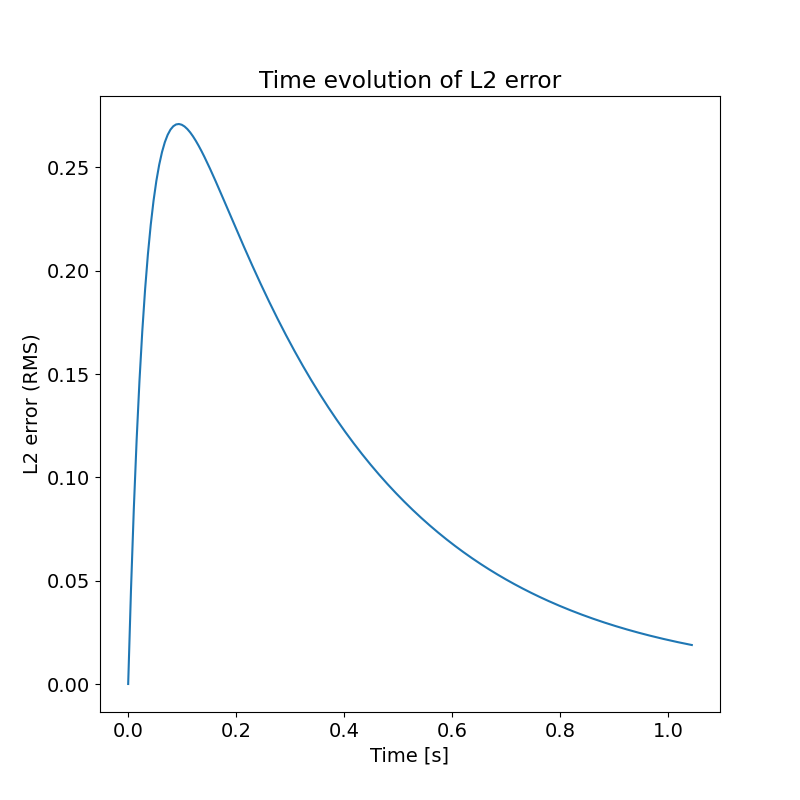

In [9]:

dens0 = dens.where(mask) #- np.nanmean(dens.where(mask), axis=(1,2), keepdims=True)
true0 = dens_true.where(mask) #- np.nanmean(dens_true.where(mask), axis=(1,2), keepdims=True)
dens_diff0 = np.abs(dens0 - true0)

int_ind = 20
#dens0 = dens.values[:,int_ind:-int_ind,int_ind:-int_ind] - np.nanmean(dens.values[:,int_ind:-int_ind,int_ind:-int_ind], axis=(1,2), keepdims=True)
#true0 = dens_true.values[:,int_ind:-int_ind,int_ind:-int_ind] - np.nanmean(dens_true.values[:,int_ind:-int_ind,int_ind:-int_ind], axis=(1,2), keepdims=True)
dens_diff0 = np.abs(dens0 - true0)

dens_diff = np.abs(dens.where(mask) - dens_true.where(mask))
l2_err_t = np.sqrt(np.nanmean(dens_diff**2, axis=(1, 2)))
l2_err_n_t = np.sqrt(np.nanmean(dens_diff0**2, axis=(1, 2)))
l2_relerr_t = l2_err_t/np.sqrt(np.nanmean(dens_true**2, axis=(1,2)))
l2_relerr_n_t = l2_err_n_t/np.sqrt(np.nanmean(true0**2, axis=(1,2)))

print("Dirichlet Linf int err: " + str(np.max(l2_err_t)))
print("Dirichlet L2 int err (early): "   + str(l2_err_t[timestep_for_errs_early]))
print("Dirichlet L2 int err (late): "   + str(l2_err_t[timestep_for_errs_late]))

print("Neumann Linf int err: " + str(np.max(l2_err_n_t)))
print("Neumann L2 int err (early): "   + str(l2_err_n_t[timestep_for_errs_early]))
print("Neumann L2 int err (late): "   + str(l2_err_n_t[timestep_for_errs_late]))

#l2_err = np.sqrt(np.nanmean(dens_diff[100,:,:]**2))
#l2_unnorm = np.sqrt(np.nansum(dens_diff[100,:,:]**2)*dx*dz)
#l2_rel = np.sqrt(np.nansum(dens_diff[100,:,:]**2)*dx*dz) / np.sqrt(np.nansum(dens_true[100,:,:]**2)*dx*dz)
#print("L2 (RMS): "    + str(l2_err))
#print("L2 (unnorm): " + str(l2_unnorm))
#print("L2 (rel): "    + str(l2_rel))
#
true = dens_true.values[1:10, len(x)//2, len(z)//2] - dens_true.values[0, len(x)//2, len(z)//2]
sim = dens.values[1:10, len(x)//2, len(z)//2] - dens.values[0, len(x)//2, len(z)//2]
#print(*np.abs(sim-true), sep="\n")

init_dens_diff = dens_diff[0,:,:]
mask2 = init_dens_diff.notnull() & (init_dens_diff >= 1e-10)
nerrs = int(mask2.sum().compute())

ii, jj = np.where(mask2)

if nerrs > 0:
    print(init_dens_diff.values[ii[0],jj[0]])
    print(dens.values[0,ii[0],jj[0]])
    print(dens_true.values[0,ii[0],jj[0]])

print(nerrs)

plt.close('all')      # optional, but guarantees a clean slate for the whole kernel
print(l2_err_n_t[-1])
fig, ax = plt.subplots()  # new figure/axes each run
ax.plot(t_norm, l2_err_n_t)
ax.set_xlabel("Time [s]")
ax.set_ylabel("L2 error (RMS)")
ax.set_title("Time evolution of L2 error")
plt.show()


Nh+ data passed has 3 dimensions - will use animatplot.blocks.Pcolormesh()


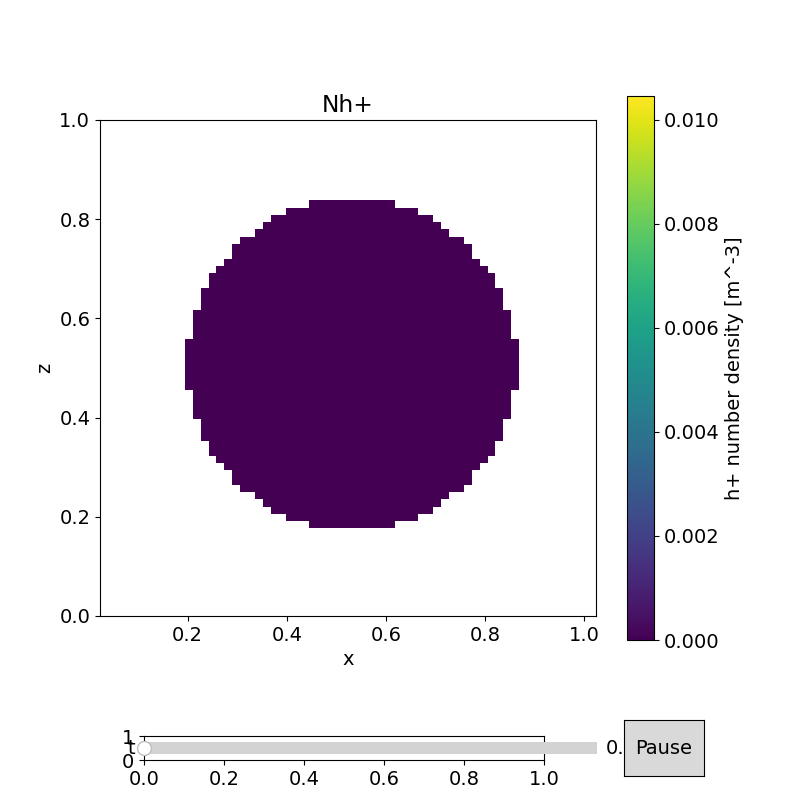

In [12]:
#dens_diff0log = np.log(dens_diff0)

dens_diff.bout.animate2D(aspect='equal')

In [ ]:
res_true = (D/(x_unit*x_unit*w_unit))*(beta0**2/(a/x_unit)**2)*dens_true.where(mask)[0,:,:]
res_sim = ds["SNh+"][0,2:-2,:].where(mask)

res = res_sim - res_true

print(np.shape(res))

res_L2 = np.sqrt(np.nansum((res**2)) * dx*dz)
print("||res||_L2 =", float(res_L2)) #, "   relative =", float(rel_res))

In [ ]:
print(dens0.values[0,len(x)//2, len(z)//2])
print(true0.values[0,len(x)//2, len(z)//2])
print(dens0.values[1,len(x)//2, len(z)//2])
print(true0.values[1,len(x)//2, len(z)//2])
print((dens0 - true0).values[1,len(x)//2,len(z)//2])

In [ ]:
print(dens.values[0,len(x)//2, len(z)//2])
print(dens_true.values[0,len(x)//2, len(z)//2])
print(dens.values[1,len(x)//2, len(z)//2])
print(dens_true.values[1,len(x)//2, len(z)//2])
print((dens - dens_true).values[1,len(x)//2,len(z)//2])

In [ ]:
import numpy as np

def build_core_mask(fluid_mask):
    """
    Erode by 1 cell so a 2nd-order centered stencil fits entirely in the fluid.
    fluid_mask: (ny, nx) bool (True = fluid)
    returns    : (ny, nx) bool 'core' mask
    """
    f = np.asarray(fluid_mask, dtype=bool)
    core = f.copy()
    # require 4-neighbors to be fluid
    core[:-1,:]  &= f[1:,:]
    core[1:,:]   &= f[:-1,:]
    core[:,:-1]  &= f[:,1:]
    core[:,1:]   &= f[:,:-1]
    # strip outer ring so centered diffs are valid
    core[[0,-1],:] = False
    core[:,[0,-1]] = False
    return core

def h1_seminorm_time(u_h, u_mms, fluid_mask, dx, dy, w_frac=None):
    """
    u_h, u_mms : (nt, ny, nx)
    fluid_mask : (ny, nx) bool (True = fluid; False = solid/ghost)
    dx, dy     : scalars
    w_frac     : optional (ny, nx) fractional fluid areas ∈[0,1]
    returns    : (nt,) H1 seminorm (gradients only) over interior core
    """
    u_h   = np.asarray(u_h);   u_mms = np.asarray(u_mms)
    nt, ny, nx = u_h.shape
    assert u_mms.shape == (nt, ny, nx), "u_h and u_mms shapes must match"

    # centered diffs
    ux_h   = (u_h[:, :, 2:] - u_h[:, :, :-2]) / (2.0*dx)   # (nt, ny,   nx-2)
    ux_mms = (u_mms[:, :, 2:] - u_mms[:, :, :-2]) / (2.0*dx)
    uy_h   = (u_h[:, 2:, :] - u_h[:, :-2, :]) / (2.0*dy)   # (nt, ny-2, nx)
    uy_mms = (u_mms[:, 2:, :] - u_mms[:, :-2, :]) / (2.0*dy)

    # align to common interior footprint: (nt, ny-2, nx-2)
    ex = (ux_h - ux_mms)[:, 1:-1, :]     # drop first/last y
    ey = (uy_h - uy_mms)[:, :, 1:-1]     # drop first/last x
    grad_err_sq = ex**2 + ey**2          # (nt, ny-2, nx-2) = (nt, 254, 258)

    # core mask (same (ny,nx) grid as u), then crop to (ny-2,nx-2)
    core = build_core_mask(fluid_mask)           # (ny, nx)
    core_int = core[1:-1, 1:-1]                  # (ny-2, nx-2)

    # weights on (ny-2, nx-2)
    if w_frac is None:
        weights2d = core_int.astype(float)
    else:
        wf = np.asarray(w_frac, dtype=float)
        assert wf.shape == (ny, nx), "w_frac must be (ny, nx)"
        weights2d = core_int.astype(float) * wf[1:-1, 1:-1]

    # weighted integral over space (2-D weights broadcast over time)
    num = np.sum(grad_err_sq * weights2d, axis=(1, 2)) * dx * dy     # (nt,)
    den = np.sum(weights2d) * dx * dy + 1e-300                       # scalar

    return np.sqrt(num / den)


# Example:
# core_mask is 2D and constant in time
H1_series = h1_seminorm_time(dens, dens_true, mask, dx, dz)
H1_final  = H1_series[-1]

print(H1_series[10])

In [ ]:
import numpy as np

def build_core_mask(fluid_mask, radius=1):
    """Binary-erosion by `radius` cells so centered stencils stay inside the fluid."""
    f = np.asarray(fluid_mask, dtype=bool)
    core = f.copy()
    for _ in range(radius):
        core[:-1,:]  &= f[1:,:]
        core[1:,:]   &= f[:-1,:]
        core[:,:-1]  &= f[:,1:]
        core[:,1:]   &= f[:,:-1]
        core[[0,-1],:] = False
        core[:,[0,-1]] = False
        f = core
    return core

def l2_interior_gaugefree_time(u_h, u_mms, fluid_mask, dx, dy, w_frac=None, radius=1):
    """
    u_h, u_mms : (nt, ny, nx) fields at the same times
    fluid_mask : (ny, nx) bool (True = fluid, False = solid/ghost)
    dx, dy     : grid spacings (uniform). For nonuniform, fold areas into w_frac.
    w_frac     : optional (ny, nx) fractional fluid areas in [0,1]; defaults to 1 on core
    radius     : erosion in cells to define the *interior* core (e.g., 1–3)
    returns    : (nt,) L2 errors on the interior core after removing best-fit constant
    """
    u_h   = np.asarray(u_h);   u_mms = np.asarray(u_mms)
    nt, ny, nx = u_h.shape
    assert u_mms.shape == (nt, ny, nx), "u_h and u_mms must match shape"

    # Interior core (same grid as fields)
    core = build_core_mask(fluid_mask, radius=radius)   # (ny, nx)

    # Weights on the core
    if w_frac is None:
        weights2d = core.astype(float)                  # 1.0 on core, 0 elsewhere
    else:
        wf = np.asarray(w_frac, dtype=float)
        assert wf.shape == (ny, nx), "w_frac must be (ny, nx)"
        weights2d = core.astype(float) * wf             # fractional areas on core

    # Best-fit constant per time over *the same* interior weights
    # C*(t) = argmin || (u_h - u_mms - C) ||_L2(core)
    w_sum_cells = np.sum(weights2d)                     # dimensionless cell-weight sum
    if w_sum_cells == 0:
        raise ValueError("Interior core is empty; increase domain or reduce radius.")
    diff = u_h - u_mms                                  # (nt, ny, nx)
    C_t  = np.sum(diff * weights2d, axis=(1,2)) / (w_sum_cells + 1e-300)  # (nt,)

    # Gauge-free error on the core
    e = diff - C_t[:, None, None]                       # (nt, ny, nx)
    e2 = (e**2) * weights2d                             # (nt, ny, nx)

    # Proper L2 with area normalization
    area_core = w_sum_cells * dx * dy                   # total physical area of core
    num = np.sum(e2, axis=(1,2)) * dx * dy             # integrate over area
    return np.sqrt(num / (area_core + 1e-300))         # (nt,)

# core away from the IB; radius=1 for 2nd-order centered diffs,
# bump to 2–3 if you still see boundary contamination.
L2_series = l2_interior_gaugefree_time(dens, dens_true, mask, dx, dz,
                                       w_frac=None, radius=1)
L2_final = L2_series[-1]

print(L2_series[10])